In [2]:
!pip install --disable-pip-version-check -q awswrangler==2.14.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.0.11 requires pandas>=2, but you have pandas 1.3.5 which is incompatible.
dask-expr 1.0.11 requires pyarrow>=7.0.0, but you have pyarrow 6.0.1 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
sphinx 7.2.6 requires docutils<0.21,>=0.18.1, but you have docutils 0.16 which is incompatible.


In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [4]:
import boto3
import sagemaker
import pandas as pd
from pyathena import connect

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

s3 = boto3.resource('s3')
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
default_s3_bucket_name = bucket
print(default_s3_bucket_name)

sagemaker-us-east-1-652903355321


In [6]:
s3_private_path_csv = "s3://{}/FinalProjectDataset/csv".format(bucket)
print(s3_private_path_csv)

s3://sagemaker-us-east-1-652903355321/FinalProjectDataset/csv


In [7]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
print(s3_staging_dir)

s3://sagemaker-us-east-1-652903355321/athena/staging


In [8]:
s3.Object(bucket, 'FinalProjectDataset/csv/olist_customers_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_customers_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_geolocation_dataset1.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_geolocation_dataset1.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_geolocation_dataset2.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_geolocation_dataset2.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_order_items_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_order_items_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_order_payments_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_order_payments_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_order_reviews_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_order_reviews_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_orders_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_orders_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_products_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_products_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/olist_sellers_dataset.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/olist_sellers_dataset.csv', 'rb'))
s3.Object(bucket, 'FinalProjectDataset/csv/product_category_name_translation.csv').put(Body=open('/root/aai-540-labs/MLOpsFinalProject/ProjectDataset/product_category_name_translation.csv', 'rb'))

{'ResponseMetadata': {'RequestId': 'JH4DXXVRHFXXTFBW',
  'HostId': 'KzuyW6PTY+dlEn6Kz9J1k280srH1i8KasZb4h6mvY25ISWnIH1JWCET1rX08YcRFtGHLd+XYEYCgo+g+dtn0AA==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KzuyW6PTY+dlEn6Kz9J1k280srH1i8KasZb4h6mvY25ISWnIH1JWCET1rX08YcRFtGHLd+XYEYCgo+g+dtn0AA==',
   'x-amz-request-id': 'JH4DXXVRHFXXTFBW',
   'date': 'Wed, 22 May 2024 00:09:03 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"4196d142e8f2b9697521fc50c97f626b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"4196d142e8f2b9697521fc50c97f626b"',
 'ServerSideEncryption': 'AES256'}

In [9]:
!aws s3 ls $s3_private_path_csv/

2024-05-22 00:09:00    9033957 olist_customers_dataset.csv
2024-05-22 00:09:01   23400724 olist_geolocation_dataset1.csv
2024-05-22 00:09:01   23582346 olist_geolocation_dataset2.csv
2024-05-22 00:09:02   15438671 olist_order_items_dataset.csv
2024-05-22 00:09:02    5777138 olist_order_payments_dataset.csv
2024-05-22 00:09:02   14451670 olist_order_reviews_dataset.csv
2024-05-22 00:09:03   17654914 olist_orders_dataset.csv
2024-05-22 00:09:03    2379446 olist_products_dataset.csv
2024-05-22 00:09:03     174703 olist_sellers_dataset.csv
2024-05-22 00:09:03       2613 product_category_name_translation.csv


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

s3_client = boto3.client("s3", region_name=region)

#housing_data_bucket_name = default_s3_bucket_name
customer_data_file_key = (
    "FinalProjectDataset/csv/olist_customers_dataset.csv"
)
geolocation_data_file1_key = (
    "FinalProjectDataset/csv/olist_geolocation_dataset1.csv"
)
geolocation_data_file2_key = (
    "FinalProjectDataset/csv/olist_geolocation_dataset2.csv"
)
items_data_file_key = (
    "FinalProjectDataset/csv/olist_order_items_dataset.csv"
)
order_payments_data_file_key = (
    "FinalProjectDataset/csv/olist_order_payments_dataset.csv"
)
order_reviews_data_file_key = (
    "FinalProjectDataset/csv/olist_order_reviews_dataset.csv"
)
orders_data_file_key = (
    "FinalProjectDataset/csv/olist_orders_dataset.csv"
)
products_data_file_key = (
    "FinalProjectDataset/csv/olist_products_dataset.csv"
)
sellers_data_file_key = (
    "FinalProjectDataset/csv/olist_sellers_dataset.csv"
)
product_category_name_translation_data_file_key = (
    "FinalProjectDataset/csv/product_category_name_translation.csv"
)

customer_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=customer_data_file_key
)
geolocation_data_object1 = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=geolocation_data_file1_key
)
geolocation_data_object2 = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=geolocation_data_file2_key
)
items_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=items_data_file_key
)
order_payments_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=order_payments_data_file_key
)
order_reviews_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=order_reviews_data_file_key
)
orders_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=orders_data_file_key
)
products_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=products_data_file_key
)
sellers_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=sellers_data_file_key
)
product_category_name_translation_data_object = s3_client.get_object(
    Bucket=default_s3_bucket_name, Key=product_category_name_translation_data_file_key
)

customer_data = pd.read_csv(io.BytesIO(customer_data_object["Body"].read()))
geolocation_data1 = pd.read_csv(io.BytesIO(geolocation_data_object1["Body"].read()))
geolocation_data2 = pd.read_csv(io.BytesIO(geolocation_data_object2["Body"].read()))
order_items_data = pd.read_csv(io.BytesIO(items_data_object["Body"].read()))
order_payments_data = pd.read_csv(io.BytesIO(order_payments_data_object["Body"].read()))
order_reviews_data = pd.read_csv(io.BytesIO(order_reviews_data_object["Body"].read()))
orders_data = pd.read_csv(io.BytesIO(orders_data_object["Body"].read()))
products_data = pd.read_csv(io.BytesIO(products_data_object["Body"].read()))
sellers_data = pd.read_csv(io.BytesIO(sellers_data_object["Body"].read()))
product_category_name_translation_data = pd.read_csv(io.BytesIO(product_category_name_translation_data_object["Body"].read()))

In [11]:
customer_data.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [14]:
geolocation_data1.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [15]:
order_items_data.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [16]:
order_payments_data.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [17]:
order_reviews_data.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [18]:
orders_data.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [19]:
products_data.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [20]:
sellers_data.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [21]:
product_category_name_translation_data.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


In [22]:
# Merge data stored in various tables
merged_df = orders_data.merge(order_reviews_data, on='order_id')\
                   .merge(order_payments_data, on='order_id')\
                   .merge(customer_data, on='customer_id')\
                   .merge(order_items_data, on='order_id')\
                   .merge(products_data, on='product_id')\
                   .merge(sellers_data, on='seller_id')
# Drop duplicates
merged_df = merged_df.drop_duplicates()

In [23]:
merged_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,b46f1e34512b0f4c74a72398b03ca788,4,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,dc90f19c2806f1abba9e72ad3c350073,5,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP


In [40]:
from scipy import stats
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
    
df_summary(merged_df)

Dataset Shape: (117329, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
2,order_status,object,0,7,delivered,0.19
3,order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42
4,order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26
5,order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02
6,order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39
7,order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
9,review_score,int64,0,5,4,1.77


In [41]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at', 
                    'order_delivered_carrier_date', 'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
merged_df[datetime_columns] = merged_df[datetime_columns].apply(pd.to_datetime)

In [42]:
df_summary(merged_df)

Dataset Shape: (117329, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
2,order_status,object,0,7,delivered,0.19
3,order_purchase_timestamp,datetime64[ns],0,97370,2017-10-02 10:56:33,16.42
4,order_approved_at,datetime64[ns],15,89533,2017-10-02 11:07:15,16.26
5,order_delivered_carrier_date,datetime64[ns],1235,80449,2017-10-04 19:55:00,16.02
6,order_delivered_customer_date,datetime64[ns],2471,95021,2017-10-10 21:25:13,16.39
7,order_estimated_delivery_date,datetime64[ns],0,449,2017-10-18 00:00:00,8.47
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
9,review_score,int64,0,5,4,1.77


In [44]:
numeric_columns = ['review_score', 'payment_sequential', 'payment_installments',
                   'payment_value', 'price', 'freight_value', 'product_name_lenght',
                   'product_description_lenght', 'product_photos_qty', 'product_weight_g',
                   'product_length_cm', 'product_height_cm', 'product_width_cm']
numeric_df = merged_df[numeric_columns]
corr = numeric_df.corr()

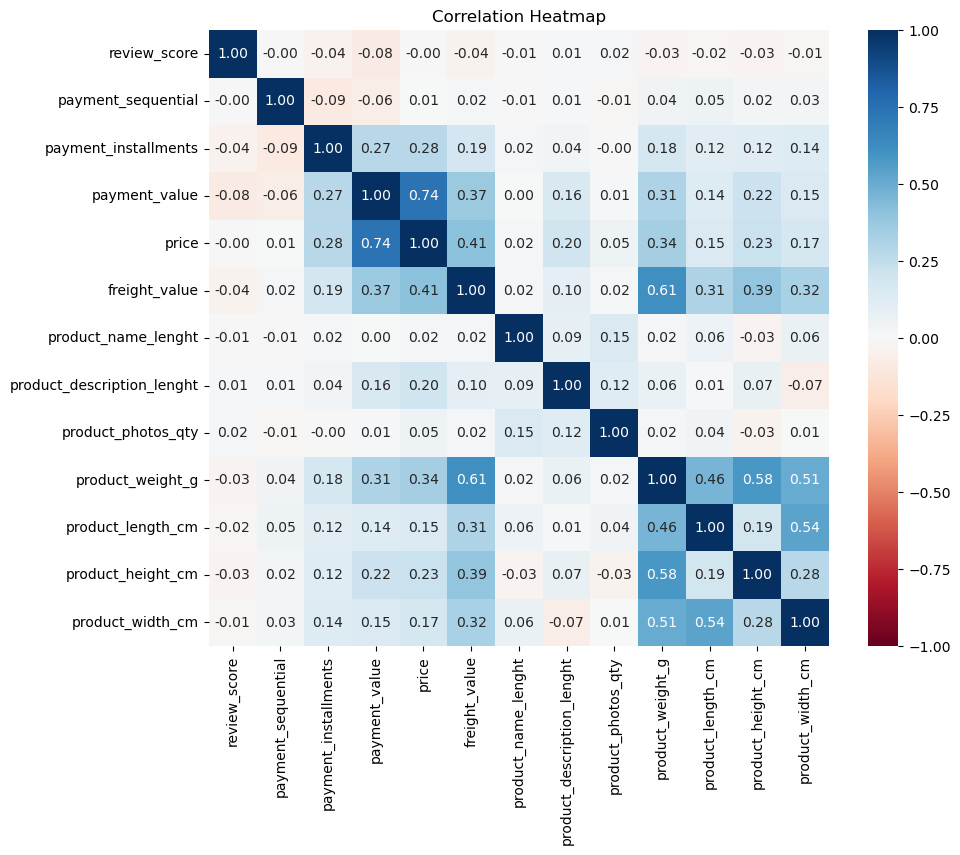

In [45]:
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
#sns.set_theme(context="notebook", style="darkgrid", palette="pastel")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

### the price, freight value (transportation and delivery cost), and product weight are most correlated with the payment value

In [46]:
corr_payment_value = corr.loc[(corr['payment_value'] > 0.3) | (corr['payment_value'] <= -0.3)]
corr_payment_value

,review_score,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
payment_value,-0.082404,-0.064475,0.274334,1.000000,0.741433,0.374270,0.003298,0.156257,0.009833,0.305458,0.139966,0.216773,0.148374
price,-0.004515,0.006717,0.279000,0.741433,1.000000,0.414014,0.017853,0.201950,0.052378,0.340712,0.145386,0.225115,0.172667
freight_value,-0.037076,0.021956,0.185774,0.374270,0.414014,1.000000,0.022442,0.096853,0.021786,0.611302,0.309137,0.394332,0.324993
product_weight_g,-0.028641,0.044021,0.177936,0.305458,0.340712,0.611302,0.021031,0.064236,0.021121,1.000000,0.462499,0.582490,0.506340


In [49]:
summary_temp=merged_df
summary_temp['order_purchase_date']=merged_df['order_purchase_timestamp'].dt.date
order_counts = summary_temp.groupby('order_purchase_date').size().reset_index(name='order_count')
order_counts.head(5)

,order_purchase_date,order_count
0,2016-09-04,2
1,2016-09-05,1
2,2016-10-02,1
3,2016-10-03,8
4,2016-10-04,76


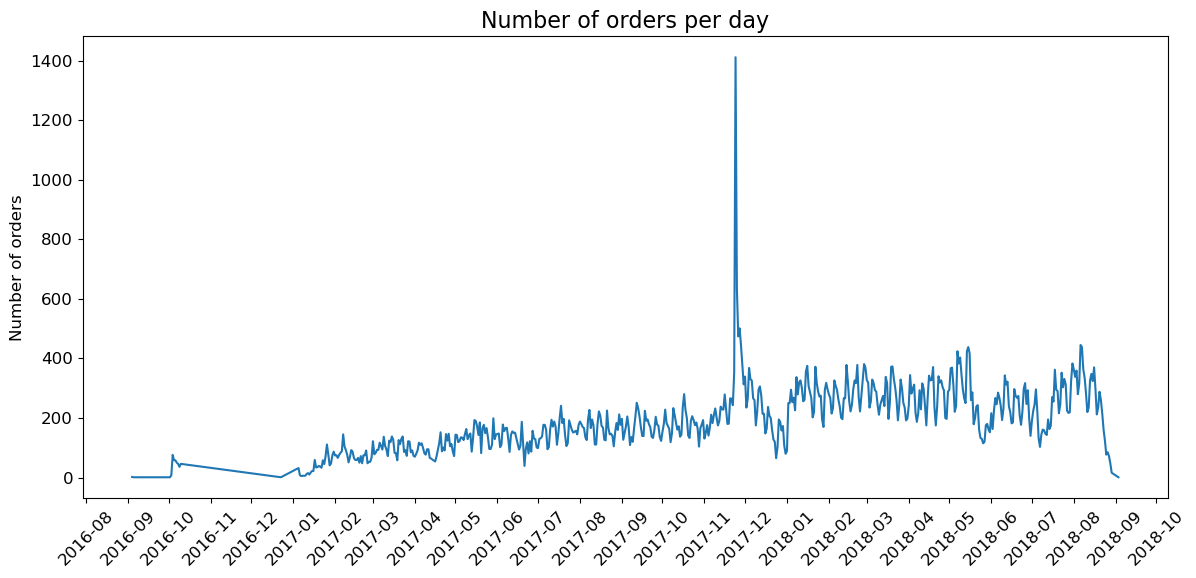

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase the default font size globally
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(order_counts['order_purchase_date']), order_counts['order_count'])
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

### We can see there's a large spike of orders around Christmas, specifically on the 24th of december. The number of orders also seems to be increasing steadily over time 

In [16]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>